<a href="https://colab.research.google.com/github/JLuceroVasquez/ia-aumentada-prevision-de-atrasos-de-vuelos/blob/main/optimizaci%C3%B3n_aeroportuaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IA aumentada: previsión de atrasos de vuelos**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import yellowbrick

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de scikit-learn (sklearn): {sklearn.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de yellowbrick: {yellowbrick.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de scikit-learn (sklearn): 1.6.1
Versión de seaborn: 0.13.2
Versión de yellowbrick: 1.5


##**CLASE 1**

###**Importación de datos**

In [3]:
#Leer el encode
'''
import chardet
with open('/content/flights.csv', 'rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']
print(encode)
'''

"\nimport chardet\nwith open('/content/flights.csv', 'rb') as f:\n  diccionario = chardet.detect(f.read())\n  encode = diccionario['encoding']\nprint(encode)\n"

In [4]:
#Importar los datos
url='https://github.com/JLuceroVasquez/ia-aumentada-prevision-de-atrasos-de-vuelos/raw/refs/heads/main/flights.csv'
datos= pd.read_csv(url, encoding='ascii')

#Visualizar  registros al azar
datos.sample(5)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
64771,23,YE,Embraer E175,schengen,TCY,18.801235,21.801235,303,2021,False,-0.089420
16999,29,BZ,Boeing 737,schengen,ZQO,8.591208,11.591208,38,2013,False,1.168253
63777,23,YE,Embraer E175,schengen,TCY,18.801235,21.801235,236,2021,False,45.459282
14000,4,BZ,Airbus A330,schengen,TCY,11.781391,14.781391,203,2012,False,-3.506809
64496,24,BZ,Airbus A320,schengen,FJB,9.668655,12.668655,284,2021,False,12.168112


In [5]:
#Visualiza la metadata
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [6]:
#Convertir las columnas categóricas a tipo category
datos = datos.astype({col: 'category' for col in datos.select_dtypes([object, bool]).columns})
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   flight_id       71175 non-null  int64   
 1   airline         71175 non-null  category
 2   aircraft_type   71175 non-null  category
 3   schengen        71175 non-null  category
 4   origin          71175 non-null  category
 5   arrival_time    71175 non-null  float64 
 6   departure_time  71175 non-null  float64 
 7   day             71175 non-null  int64   
 8   year            71175 non-null  int64   
 9   is_holiday      71175 non-null  category
 10  delay           71175 non-null  float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 3.6 MB


###**Análisis de las variables categóricas**

In [8]:
#Reporte de métricas: Variables categóricas
datos.describe(include='category')

,airline,aircraft_type,schengen,origin,is_holiday
count,71175,71175,71175,71175,71175
unique,3,6,2,10,2
top,BZ,Airbus A320,schengen,TZF,False
freq,47598,30778,42569,14162,67275


In [37]:
#Insumos
y_name = 'delay'
X_names = datos.select_dtypes('category').columns

'''
En el futuro, el comportamiento por defecto del parámetro observed cuando se
agrupan datos (groupby) que tienen columnas categóricas (category) será True.
Por eso, a fin de evitar mensajes de avertencia, se establece como True en la
función groupby. Esto incluirá solo las categorías presentes en los datos }
agrupados, omitiendo las que no aparecen (si es que se configuraron adicionales
al crear el dataframe).

Por ejemplo:
df = pd.DataFrame({
    'A': pd.Categorical(['x', 'y'], categories=['x', 'y', 'z']),
    'B': [1, 2]
})
'''
df_delay = []
for predictor in X_names:
  df = datos.groupby(predictor, observed=True)[y_name].mean().sort_values(ascending=False).reset_index()
  df_delay.append(df)

lista_orden = []
for predictor in X_names:
  lista = datos[predictor].value_counts().index.tolist()
  lista_orden.append(lista)

**Funciones personalizadas para graficar con Seaborn en subplots**

Ambas funciones reciben un eje específico de Matplotlib (ax) para que el gráfico
se dibuje dentro de una figura con múltiples subplots, lo cual es útil para
visualizaciones comparativas.

*Parámetros comunes:*

* x_name: nombre de la columna que irá en el eje X.

* y_name: (solo en barplot_delay) nombre de la columna que irá en el eje Y.

* df: DataFrame que contiene los datos.

* bar_order: (solo en countplot_vuelos) lista con los nombres de las categorías en el orden que irán en el eje X.

* rotation_xticks: ángulo de rotación para las etiquetas del eje X.

* ax: objeto Axes de Matplotlib donde se dibujará el gráfico.

*barplot_delay():*

    Crea un gráfico de barras (sns.barplot) que muestra el valor promedio de y_name
    según cada categoría de x_name. Es ideal para comparar promedios agrupados.

*countplot_vuelos():*

    Crea un gráfico de conteo (sns.countplot) que muestra cuántas veces aparece
    cada categoría de x_name en el DataFrame. Permite ordenar las barras si se
    pasa una lista en bar_order.

*Ambas funciones:*

* Usan ax.set_title(), ax.set_xlabel() y ax.set_ylabel() para personalizar textos.

* Usan ax.set_xticklabels(..., rotation=...) para rotar etiquetas y mejorar legibilidad.

* Devuelven el objeto Axes, lo que permite encadenar personalizaciones si se desea.

In [41]:
#Herramientas
def barplot_delay(x_name, y_name, df, bar_order=None, rotation_xticks: float = 0, ax=None):
    ax = sns.barplot(x=x_name, y=y_name, data=df, order=bar_order, ax=ax)
    ax.set_title(f'{y_name} según {x_name}')
    ax.set_xlabel(x_name)
    ax.set_ylabel('Atraso promedio en minutos')
    ax.tick_params(axis='x', rotation=rotation_xticks)
    return ax

def countplot_vuelos(x_name, df, bar_order=None, rotation_xticks: float = 0, ax=None):
    ax = sns.countplot(data=df, x=x_name, order=bar_order, ax=ax)
    ax.set_title(f'Cantidad de vuelos según {x_name}')
    ax.set_xlabel(x_name)
    ax.set_ylabel('Cantidad de vuelos')
    ax.tick_params(axis='x', rotation=rotation_xticks)
    return ax

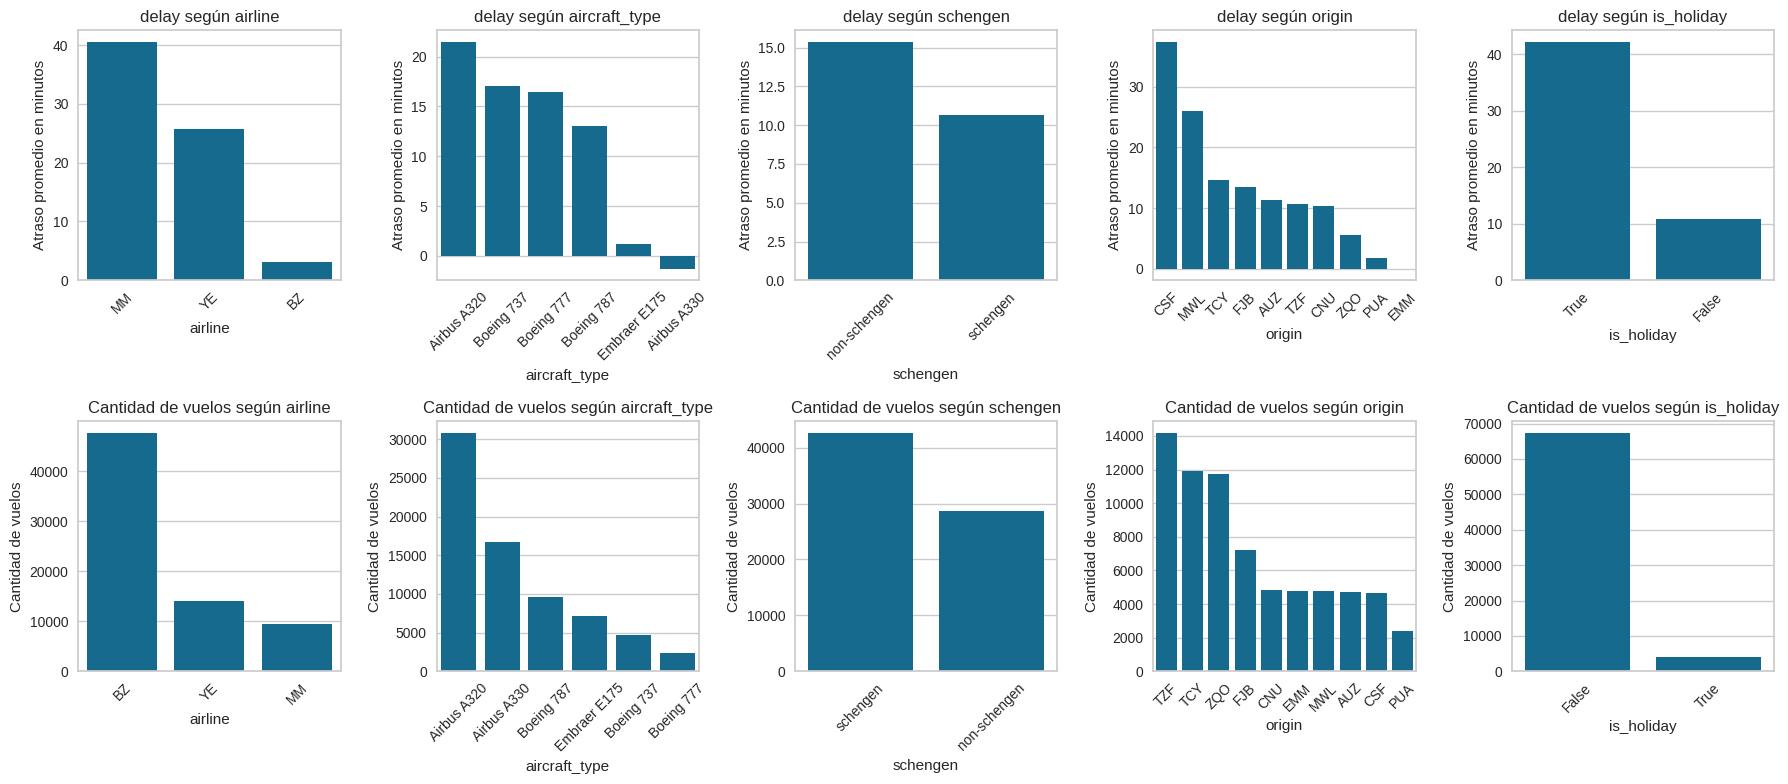

In [43]:
#Visualización
# Crear figura y ejes
fig, axs = plt.subplots(2, 5, figsize=(18, 8))

# Primera fila -> barplot
'''
axs.flat no es un objeto que soporte slicing directo (axs.flat[:5]), porque es
un iterador de NumPy, no una lista. Por eso se convierte a lista.
'''
for i, ax in enumerate(list(axs.flat)[:5]): # Solo primeros 5 (primera fila)
  bar_order = df_delay[i][X_names[i]].unique().tolist() #Generamos una lista con el orden de las categorías del eje X
  barplot_delay(X_names[i], y_name, df_delay[i], bar_order=bar_order, rotation_xticks=45, ax=ax)

# Segunda fila -> countplot
for i, ax in enumerate(list(axs.flat)[5:]): # Los últimos 5 (segunda fila)
  countplot_vuelos(X_names[i], datos, bar_order=lista_orden[i], rotation_xticks=45, ax=ax)

plt.tight_layout()
plt.show()

###**Análisis de las variable numéricas**

In [7]:
#Reporte de métricas: Variables numéricas
datos.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


**Variables excluidas del análisis**

Las variables numéricas del dataframe datos son las siguientes:

    'flight_id', 'arrival_time', 'departure_time', 'day', 'year', 'delay'

Sin embargo, no se analizó las variables `flight_id` y `year` debido a que no contribuyen información relevante para la predicción de retrasos de vuelos.

* `flight_id:` Aunque esté codificada como numérica, en realidad es una identificación única de cada vuelo.
* `year:` Es una variable histórica. Si el modelo será usado para predecir retrasos de vuelos futuros, no tendrá sentido incluir un valor de año que esos datos no contengan. Además, en este caso, el efecto estacional del año se capta indirectamente a través de otras variables como `'day'`.

Excluir siempre identificadores y campos no disponibles en datos futuros es una buena práctica para evitar [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage).

**Cálculo del ancho de los intervalos**

Para los gráficos de histograma, se calculó el ancho de los intervalos usando la [regla Diaconis](https://www.google.com/url?q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FFreedman%25E2%2580%2593Diaconis_rule).

In [51]:
#Insumos
col_names = ['arrival_time', 'departure_time', 'day', 'delay']

#Lista de medianas
medianas = {}
for col in col_names:
  medianas[col] = datos[col].median()

#Lista de medias
medias = {}
for col in col_names:
  medias[col] = datos[col].mean()

#Función para el cálculo de ancho de intervalo usando
def anchointervalo(df, col):
  q1, q3 = np.percentile(a=df[col], q=[25,75])
  iqr = q3 - q1
  ancho = 2 * iqr / (len(df) ** (1/3))
  return ancho
#Lista de ancho de intervalo
anchos = {}
for col in col_names:
  anchos[col] = anchointervalo(datos, col)

**Funciones para los gráficos**

La función **boxplot_numericas** recibe el nombre de una columna numérica, un DataFrame y opcionalmente un objeto de ejes de Matplotlib. Utiliza Seaborn para crear un diagrama de caja de la columna especificada sobre el eje indicado. Agrega una línea horizontal roja discontinua para marcar la media de la columna, extraída del diccionario global medias, y añade una leyenda para identificarla. Devuelve el objeto de ejes para permitir su integración en figuras con múltiples gráficos.

La función **histplot_numericas** recibe parámetros similares, pero genera un histograma con densidad (kde) utilizando Seaborn. Configura el ancho de las barras a partir del valor correspondiente en el diccionario global anchos. El histograma se complementa con una línea roja discontinua para la media y una línea amarilla discontinua para la mediana, tomadas de los diccionarios globales medias y medianas, respectivamente. También se desactiva la cuadrícula, se establecen títulos y etiquetas, y se añade una leyenda para identificar las referencias. Al igual que la anterior, devuelve el objeto de ejes para su posterior manipulación o visualización en conjuntos de gráficos.

In [52]:
#Herramientas
def boxplot_numericas(col, df, ax=None):
  ax = sns.boxplot(data=df, y=col, ax=ax)
  ax.set_title(f'Boxplot de {col}')
  ax.axhline(y=medias[col], color='r', linestyle='--', label='Media')
  ax.legend()
  return ax

def histplot_numericas(col, df, ax=None):
  ax = sns.histplot(data=df, x=col, ax=ax, kde=True, binwidth=anchos[col])
  ax.set_ylabel('Número de vuelos')
  ax.grid(False)
  ax.set_title(f'Histograma de {col}')
  ax.axvline(x=medias[col], color='r', linestyle='--', label='Media')
  ax.axvline(x=medianas[col], color='y', linestyle='--', label='Mediana')
  ax.legend()
  return ax

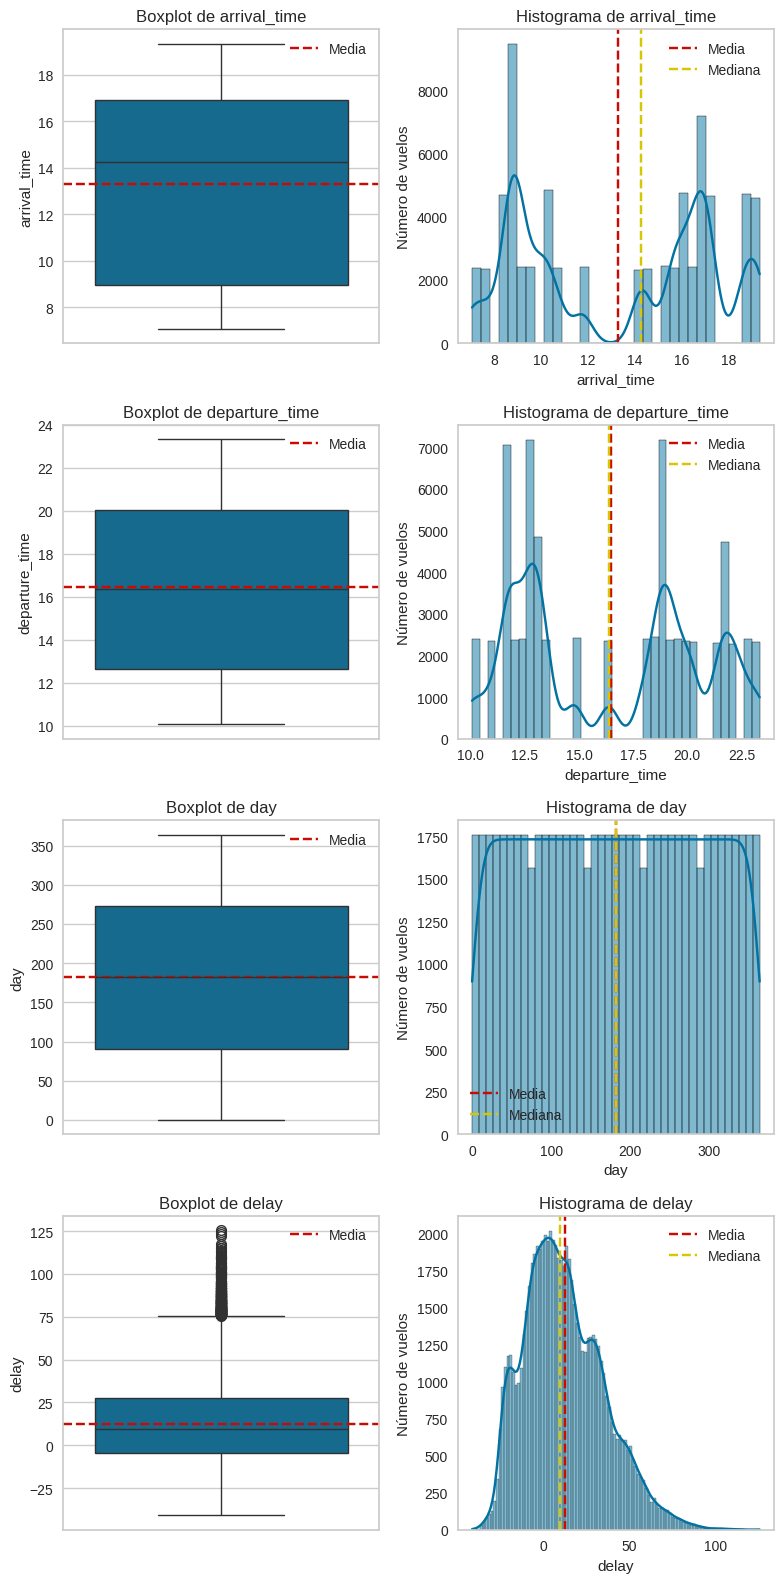

In [55]:
#Visualización
# Crear figura y ejes
fig, axs = plt.subplots(4, 2, figsize=(8, 16))

# Primera columna -> boxplot | Segunda fila -> histplot
'''
Se accede al nombre de la columna dividiendo el n° de eje entre 2 y redondeando
hacia abajo ¿Por qué? Son 8 ejes, y 4 variables numéricas. Por tanto:
Ejes                | Columna
-------------------------------------
(0, 1) // 2 = 0     | arrival_time
(2, 3) // 2 = 1     | departure_time
(4, 5) // 2 = 2     | day
(6, 7) // 2 = 3     | delay
'''
for i, ax in enumerate(axs.flat):
  if i % 2 == 0:
    boxplot_numericas(col_names[i//2], datos, ax=ax)
  else:
    histplot_numericas(col_names[i//2], datos, ax=ax)

plt.tight_layout()
plt.show()

##**CLASE 2**

##**CLASE 3**

https://scikit-learn.org/stable/

##**CLASE 4**